In [ ]:
import os
import torch

from vllm import LLM, SamplingParams
from math_verify import parse, verify

import pandas as pd
from tqdm import tqdm
from transformers import AutoTokenizer

/opt/anaconda/envs/dfr/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


INFO 11-23 13:57:39 [__init__.py:239] Automatically detected platform cuda.


2025-11-23 13:57:41,225	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [4]:
# MODEL_NAME = "Qwen/Qwen2.5-Math-1.5B"
MODEL_NAME = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"
DATA_PATH = "../hard_rl/data/MATH/{}.parquet"
NUM_ROLLOUTS_PER_QUESTION = 50

In [22]:
llm = LLM(model=MODEL_NAME, gpu_memory_utilization=0.4)

INFO 11-22 16:06:45 [config.py:717] This model supports multiple tasks: {'score', 'embed', 'classify', 'reward', 'generate'}. Defaulting to 'generate'.
INFO 11-22 16:06:45 [config.py:2003] Chunked prefill is enabled with max_num_batched_tokens=16384.
INFO 11-22 16:06:47 [core.py:58] Initializing a V1 LLM engine (v0.8.5.post1) with config: model='deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B', speculative_config=None, tokenizer='deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=131072, download_dir=None, load_format=auto, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='auto', reasoning_backend=None), observability_config=ObservabilityConfig(show_hidden_m

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  2.20it/s]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  2.19it/s]



INFO 11-22 16:06:49 [loader.py:458] Loading weights took 0.51 seconds
INFO 11-22 16:06:50 [gpu_model_runner.py:1347] Model loading took 3.3461 GiB and 1.094259 seconds
INFO 11-22 16:06:54 [backends.py:420] Using cache directory: /home/lina4335/.cache/vllm/torch_compile_cache/9a365a3533/rank_0_0 for vLLM's torch.compile
INFO 11-22 16:06:54 [backends.py:430] Dynamo bytecode transform time: 4.32 s
INFO 11-22 16:06:57 [backends.py:118] Directly load the compiled graph(s) for shape None from the cache, took 3.094 s
INFO 11-22 16:06:58 [monitor.py:33] torch.compile takes 4.32 s in total
INFO 11-22 16:06:58 [kv_cache_utils.py:634] GPU KV cache size: 950,896 tokens
INFO 11-22 16:06:58 [kv_cache_utils.py:637] Maximum concurrency for 131,072 tokens per request: 7.25x
INFO 11-22 16:07:15 [gpu_model_runner.py:1686] Graph capturing finished in 16 secs, took 0.56 GiB
INFO 11-22 16:07:15 [core.py:159] init engine (profile, create kv cache, warmup model) took 25.14 seconds
INFO 11-22 16:07:15 [core_cl

In [5]:
train_df = pd.read_parquet(DATA_PATH.format("train"))
test_df = pd.read_parquet(DATA_PATH.format("test"))

In [6]:
len(train_df), len(test_df)

(12000, 500)

In [24]:
train_df_slice = train_df[:10]

In [9]:
PARAMS = SamplingParams(temperature=1, max_tokens=3000)

In [25]:
QUESTION_PROMPT = train_df_slice["prompt"].iloc[0][0]["content"]

In [35]:
input = llm.llm_engine.tokenizer.tokenizer.apply_chat_template([{"role": "user", "content": QUESTION_PROMPT}, {"role": "user", "content": QUESTION_PROMPT}], tokenize=False, add_generation_prompt=True)
input

'<｜begin▁of▁sentence｜><｜User｜>How many vertical asymptotes does the graph of $y=\\frac{2}{x^2+x-6}$ have? Let\'s think step by step and output the final answer after "\\boxed{}".<｜User｜>How many vertical asymptotes does the graph of $y=\\frac{2}{x^2+x-6}$ have? Let\'s think step by step and output the final answer after "\\boxed{}".<｜Assistant｜><think>\n'

In [11]:
train_df_slice.head()

,data_source,prompt,ability,reward_model,extra_info,level
0,lighteval/MATH,[{'content': 'How many vertical asymptotes doe...,math,"{'ground_truth': '2', 'style': 'rule'}","{'answer': '2', 'index': 0, 'level': 3, 'probl...",3
1,lighteval/MATH,"[{'content': 'If $5x - 3 = 12$, what is the va...",math,"{'ground_truth': '18', 'style': 'rule'}","{'answer': '18', 'index': 1, 'level': 2, 'prob...",2
2,lighteval/MATH,[{'content': 'Ryan has 3 red lava lamps and 3 ...,math,"{'ground_truth': '\dfrac{7}{20}', 'style': 'ru...","{'answer': '\dfrac{7}{20}', 'index': 2, 'level...",5
3,lighteval/MATH,[{'content': 'Alice wants to buy $3$ pounds of...,math,"{'ground_truth': '1.36', 'style': 'rule'}","{'answer': '1.36', 'index': 3, 'level': 4, 'pr...",4
4,lighteval/MATH,"[{'content': 'On the $xy$-plane, the origin is...",math,"{'ground_truth': '28', 'style': 'rule'}","{'answer': '28', 'index': 4, 'level': 5, 'prob...",5


In [12]:
train_df_slice["reward_model"].iloc[0]["ground_truth"]

'2'

In [13]:
QA_STORE = dict()
for i in tqdm(range(len(train_df_slice))):
    QUESTION_PROMPT = train_df_slice["prompt"].iloc[i][0]["content"]
    GROUND_TRUTH = train_df_slice["reward_model"].iloc[0]["ground_truth"]

    PER_QUESTION_RESP_STORE_LOCAL = []
    outputs = llm.generate([QUESTION_PROMPT]*NUM_ROLLOUTS_PER_QUESTION, PARAMS)
    for output in outputs:
        prompt = output.prompt
        generated_text = output.outputs[0].text
        PER_QUESTION_RESP_STORE_LOCAL.append(generated_text)
        
    QA_STORE[QUESTION_PROMPT] = {"responses": PER_QUESTION_RESP_STORE_LOCAL, "ground_truth": GROUND_TRUTH }

Processed prompts:   0%|          | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts: 100%|██████████| 50/50 [00:10<00:00,  4.67it/s, est. speed input: 359.45 toks/s, output: 2416.04 toks/s] 


In [18]:
RESULTS = {}
for prompt, v in tqdm(QA_STORE.items()):
    responses = v.get("responses", [])
    gt = v.get("ground_truth")
    correct = 0
    for resp in responses:
        try:
            ans = parse(resp)
        except Exception:
            ans = resp  # fallback to raw text
        try:
            if verify(gt, ans):
                correct += 1
        except Exception:
            pass
    total = len(responses)
    rate = correct / total if total > 0 else 0.0
    RESULTS[prompt] = {"correct": correct, "total": total, "success_rate": rate}

# optional: view as a DataFrame sorted by success_rate
results_df = pd.DataFrame.from_dict(RESULTS, orient='index').sort_values("success_rate", ascending=False)
results_df.head()

100%|██████████| 10/10 [00:01<00:00,  5.60it/s]


,correct,total,success_rate
"How many vertical asymptotes does the graph of $y=\frac{2}{x^2+x-6}$ have? Let's think step by step and output the final answer after ""\boxed{}"".",45,50,0.90
"One sphere is centered at $(3,-5,7)$ with radius $5 \sqrt{5}.$ A second sphere is centered at $(0,1,1)$ with radius $2 \sqrt{17}.$ The two spheres intersect in a circle. Find the radius of this circle. Let's think step by step and output the final answer after ""\boxed{}"".",2,50,0.04
"We have two geometric sequences of positive real numbers: $$6,a,b\text{ and }\frac{1}{b},a,54$$Solve for $a$. Let's think step by step and output the final answer after ""\boxed{}"".",2,50,0.04
"$AB = 20$ cm, $m \angle A = 30^\circ$, and $m \angle C = 45^\circ$. Express the number of centimeters in the length of $\overline{BC}$ in simplest radical form. [asy]\nimport olympiad; size(200); import geometry; import graph; defaultpen(linewidth(0.8));\npair A = origin, B = (10*sqrt(3),10), C = (10*sqrt(3) + 10,0);\ndraw(Label(""$20$"",align=NW),A--B); draw(B--C); draw(A--C);\nlabel(""$A$"",A,W); label(""$B$"",B,N); label(""$C$"",C,E);\n[/asy] Let's think step by step and output the final answer after ""\boxed{}"".",1,50,0.02
"Connie is starting an exercise program. On June 1, she will do 25 sit-ups. Each day after that, she will increase her number of sit-ups by four. On which date during the month of June will Connie first do more than 100 sit-ups in one day? Let's think step by step and output the final answer after ""\boxed{}"".",1,50,0.02


In [ ]:
results_df.to_parquet("MATH/train.parquet")

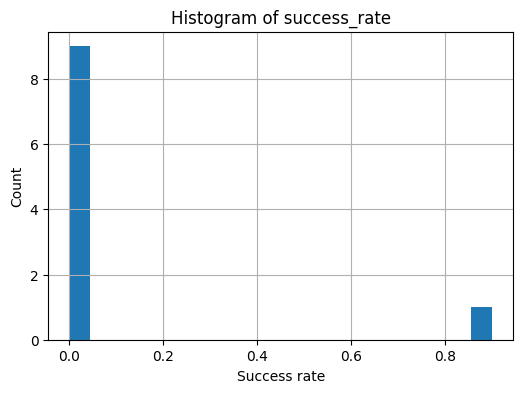

In [22]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 4))
results_df["success_rate"].hist(ax=ax, bins=20)
ax.set_xlabel("Success rate")
ax.set_ylabel("Count")
ax.set_title("Histogram of success_rate")

fig.savefig("success_rate_hist.png", dpi=300, bbox_inches="tight")
plt.show()

In [37]:
test_df["ground_truth"] = test_df["reward_model"].apply(lambda x: x["ground_truth"])
train_df["ground_truth"] = train_df["reward_model"].apply(lambda x: x["ground_truth"])

In [ ]:
SR_FILE_NAMES = "MATH_Qwen2.5-Math-1.5B-SR_{}.parquet"

In [8]:
pred_sr_train_df = pd.read_parquet(SR_FILE_NAMES.format("train"))
pred_sr_test_df = pd.read_parquet(SR_FILE_NAMES.format("test"))

In [4]:
SR_FILE_NAMES = "MATH_DeepSeek-R1-Distill-Qwen-1.5B-SR_{}.parquet"
pred_sr_train_df = pd.read_parquet(SR_FILE_NAMES.format("train"))
pred_sr_test_df = pd.read_parquet(SR_FILE_NAMES.format("test"))

In [13]:
pred_sr_train_df

,correct,total,success_rate,ground_truth,prompt
0,50,50,1.00,\text{June 20},<｜begin▁of▁sentence｜><｜User｜>How many vertical...
1,49,50,0.98,\text{June 20},"<｜begin▁of▁sentence｜><｜User｜>If $5x - 3 = 12$,..."
2,0,50,0.00,\text{June 20},<｜begin▁of▁sentence｜><｜User｜>Ryan has 3 red la...
3,50,50,1.00,\text{June 20},<｜begin▁of▁sentence｜><｜User｜>Alice wants to bu...
4,1,50,0.02,\text{June 20},<｜begin▁of▁sentence｜><｜User｜>On the $xy$-plane...
5,0,50,0.00,\text{June 20},<｜begin▁of▁sentence｜><｜User｜>One sphere is cen...
6,44,50,0.88,\text{June 20},<｜begin▁of▁sentence｜><｜User｜>In triangle $\tri...
7,50,50,1.00,\text{June 20},"<｜begin▁of▁sentence｜><｜User｜>$AB = 20$ cm, $m ..."
8,48,50,0.96,\text{June 20},<｜begin▁of▁sentence｜><｜User｜>We have two geome...
9,7,50,0.14,\text{June 20},<｜begin▁of▁sentence｜><｜User｜>Connie is startin...


In [9]:
pred_sr_train_df["ground_truth"] = None
pred_sr_test_df["ground_truth"] = None

In [13]:
# add a 'prompt' column mirroring the current index (which contains the prompt text)
if pd.api.types.is_string_dtype(pred_sr_train_df.index):
    pred_sr_train_df['prompt'] = pred_sr_train_df.index.astype(str)

pred_sr_train_df['id'] = range(1, len(pred_sr_train_df) + 1)
pred_sr_train_df = pred_sr_train_df.set_index('id')

# quick check
pred_sr_train_df.head()

,correct,total,success_rate,ground_truth,prompt
id,,,,,
1,50,50,1.0,None,What is the greatest common factor of 252 and ...
2,50,50,1.0,None,If $\det \mathbf{A} = 4$ and $\det \mathbf{B} ...
3,50,50,1.0,None,In how many ways can a 2-person committee be c...
4,50,50,1.0,None,Tamantha wants to buy boxes in which to put he...
5,50,50,1.0,None,Ten distinct points are identified on the circ...


In [15]:
# add a 'prompt' column mirroring the current index (which contains the prompt text)
if pd.api.types.is_string_dtype(pred_sr_test_df.index):
    pred_sr_test_df['prompt'] = pred_sr_test_df.index.astype(str)

pred_sr_test_df['id'] = range(1, len(pred_sr_test_df) + 1)
pred_sr_test_df = pred_sr_test_df.set_index('id')

# quick check
pred_sr_test_df.head()

,correct,total,success_rate,ground_truth,prompt
id,,,,,
1,49,50,0.98,None,"You have 5 shirts, 6 pairs of pants, and 8 hat..."
2,49,50,0.98,None,"The point $(a, b)$ lies on the line with the e..."
3,48,50,0.96,None,"Find $k$, if ${(3^k)}^6=3^6$. Let's think step..."
4,48,50,0.96,None,Determine the remainder of 54 (mod 6). Let's t...
5,47,50,0.94,None,The sum of the first $N$ positive odd numbers ...


In [16]:
pred_sr_train_df.to_parquet(SR_FILE_NAMES.format("train"))
pred_sr_test_df.to_parquet(SR_FILE_NAMES.format("test"))